In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps 
                                        
%matplotlib inline

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from statistics import mean

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models, Model 
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy, mse
from tensorflow.keras.metrics import categorical_accuracy, Mean
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as K
import tensorflow_probability as tfp

### Create train and test sets from  Iris dataset

In [ ]:
iris = datasets.load_iris()
print(iris['feature_names'])
X_orig = iris.data[:, :].astype('float32') 
y = iris.target.astype('float32')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X = scaler.fit_transform(X_orig)

In [ ]:
print(X.min())
print(X.max())
print(X.mean())

In [ ]:
plt.scatter(X[y==0, 0], X[y==0,1])
plt.scatter(X[y==1, 0], X[y==1,1])
plt.scatter(X[y==2, 0], X[y==2,1])
plt.title('Standardized Data')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

In [ ]:
X.shape

In [ ]:
y[0:5]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42,stratify=y_train)

In [12]:
print(len(y_train))
print(len(y_test))
print(len(y_val))

90
30
30


In [13]:
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)
y_val_onehot = to_categorical(y_val)

### Networks and callbacks

In [14]:
K.clear_session()

In [15]:
input = layers.Input(shape=(4,), name='myInput')

In [16]:
batch_size = 1

In [17]:
# The selector layer that outputs the expected outputs of the experts based on the gate probabilities. 
# It is a non trainable layer
class selector_expectation(Layer):
    def __init__(self,num_experts, **kwargs):
        self.num_experts = num_experts
        super(selector_expectation,self).__init__(**kwargs)

    def build(self,input_shape):
        super(selector_expectation, self).build(input_shape)
        
    def call(self,input):

        x = input[0]
        p = input[1]
        x = K.reshape(x,(batch_size, self.num_experts, 3))
        output = K.sum(K.repeat_elements(K.reshape(p,(batch_size,self.num_experts,1)), rep=3,axis=2) * x, axis=1) 
        return output

    def get_config(self):
        return super(selector_expectation,self).get_config()


In [18]:
# The selector layer that outputs a stochastic selection of an expert based on the gate probabilities. 
# It is a non trainable layer 
class selector_stochastic(Layer):
    def __init__(self,num_experts,**kwargs):
        self.num_experts = num_experts
        super(selector_stochastic,self).__init__(**kwargs)

    def build(self,input_shape):
        super(selector_stochastic, self).build(input_shape)
        
    def call(self,input):
        
        x = input[0]
        p = input[1]
        
        x = K.reshape(x,(batch_size, self.num_experts, 3))
        
#         tf.print('x:', x)
#         tf.print('p:', p)
                
        dist = tfp.distributions.Multinomial(total_count=1, probs=p)
        samples = K.reshape(dist.sample(),(batch_size,self.num_experts,1))
        output = K.sum(samples*x, axis=1)
        
#         tf.print('output:', output)

        return output
        
    def get_config(self):
        return super(selector_stochastic,self).get_config()


In [19]:
#Expert network
def expert_layers(input, output, name):
    x = layers.Dense(4,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=1.))(input)
    x = layers.Dense(output, activation='softmax',name=name)(x)
    return x

In [20]:
#Gate network (Similar to the expert layer)
def gate_layers(input, output, name):
    x = layers.Dense(4,activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=1.), kernel_regularizer='l1')(input)
    x = layers.Dense(output, activation='softmax',name=name)(x)
    return x

In [21]:
def model_loss(actual, x, p, num_experts):
    actual = K.reshape(actual,(batch_size, 1, 3))
#     tf.print('actual:', actual)
#     tf.print('x:',x)
#     tf.print('p:',p, K.shape(p))
    loss = categorical_crossentropy(K.repeat_elements(actual, rep=num_experts, axis=1), x)
    loss = K.reshape(loss, (batch_size, num_experts, 1))
#     tf.print('cc:', loss, K.shape(loss))
    loss = K.reshape(p,(batch_size,num_experts,1)) *  loss
#     tf.print('exp_loss:', loss)
    loss = K.sum(loss, axis=1)
#     tf.print('loss:',loss, K.shape(loss))
    return loss


In [22]:
# Custom Model to intercept training to analyze the gradients during training
loss_tracker = Mean(name="loss")

class CustomModelStoch(Model):
    def __init__(self, num_experts, **kwargs):
        self.num_experts = num_experts
        super(CustomModelStoch,self).__init__(**kwargs)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            exp_outputs = []
            for i in range(1, self.num_experts+1):
                exp_out = self.get_layer('dense_'+str(i))(x, training = True)
                exp_out = self.get_layer('expert_'+str(i-1))(exp_out, training = True)
                exp_outputs.append(exp_out)
                
            expert_outputs = K.reshape(K.concatenate(exp_outputs), (batch_size, self.num_experts,3))
#             tf.print('expert_outputs:', expert_outputs)     
            gate_output = self.get_layer('dense')(x, training = True)
            gate_output = self.get_layer('gate_layer')(gate_output, training = True)
#             tf.print('gate_output:', gate_output)
            
            loss = model_loss(y, expert_outputs, gate_output, self.num_experts)

        #Get the trainable weights
        trainable_vars = self.trainable_weights
        
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics 
        self.compiled_metrics.update_state(y, y_pred)
        
        metrics =  {m.name: m.result() for m in self.metrics}
        
        loss_tracker.update_state(loss)
        metrics['loss'] =  loss_tracker.result()       
        
        # Return a dict mapping metric names to current value        
        return metrics
                   
        return super(CustomModel, self).train_step(data)

In [23]:
#Callback to track the loss and mean absolute activations of each expert during training
# and track the mean absolute activations of the gate network during training
class AnalysisCallback(Callback):
    
    def __init__(self, num_experts):
        self.expert_loss = {}
        self.expert_mean_abs_act = {}
        self.gate_mean_abs_act = []
        self.num_experts = num_experts
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        for i in range(1, self.num_experts+1):
            pred = self.model.get_layer('dense_'+str(i*3))(np.reshape(x_test[15],(1,4)), training = True)
            pred = self.model.get_layer('dense_'+str((i*3)+1))(pred, training = True)
            last_activation = self.model.get_layer('dense_'+str((i*3)+2))(pred, training = True)
            pred = self.model.get_layer('expert_'+str(i-1))(last_activation, training = True)
            loss = K.mean(categorical_crossentropy(np.reshape(y_test_onehot[15],(1,3)), pred))
            if self.expert_loss.get(i) is None:
                self.expert_loss[i] = []
            else:
                self.expert_loss[i].append(loss)
            if self.expert_mean_abs_act.get(i) is None:
                self.expert_mean_abs_act[i] = []
            else:
                self.expert_mean_abs_act[i].append(K.mean(K.abs(last_activation)))

        pred = self.model.get_layer('dense')(np.reshape(x_test[15],(1,4)), training = True)
        pred = self.model.get_layer('dense_1')(pred, training = True)
        last_activation = self.model.get_layer('dense_2')(pred, training = True)
        pred = self.model.get_layer('gate_layer')(last_activation, training = True)
        self.gate_mean_abs_act.append(K.mean(K.abs(last_activation)))

    def on_train_end(self, logs=None):
        labels = []
        for i in range(1, self.num_experts+1):
            plt.plot(range(len(self.expert_loss[i])), self.expert_loss[i], label='expert '+str(i-1))
            labels.append('expert '+str(i-1))

        plt.legend(labels)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        
        labels = []
        for i in range(1, self.num_experts+1):
            plt.plot(range(len(self.expert_mean_abs_act[i])), self.expert_mean_abs_act[i], label='expert '+str(i-1))
            labels.append('expert '+str(i-1))
            
        plt.plot(range(len( self.gate_mean_abs_act)), self.gate_mean_abs_act, label='gate')
        labels.append('gate')
        plt.legend(labels)
        plt.xlabel('epochs')
        plt.ylabel('mean absolute activation')
        plt.show()
            

In [24]:
#Callback for analysis a simple model to test the standalone expert model.
class SimpleModelCallback(Callback):
    def __init__(self):
        self.simple_model_loss = []
        self.simple_model_mean_abs_act = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.get_layer('dense')(np.reshape(x_test[15],(1,4)), training=True)
        pred = self.model.get_layer('dense_1')(pred, training=True)
        last_activation = self.model.get_layer('dense_2')(pred, training=True)
        pred = self.model.get_layer('simple_model')(last_activation, training=True)
        loss = K.mean(categorical_crossentropy(np.reshape(y_test_onehot[15],(1,3)), pred))
        self.simple_model_loss.append(loss)
        
#         print(self.model.get_layer('dense_5').get_weights()[0].shape)
        self.simple_model_mean_abs_act.append(K.mean(K.abs(last_activation)))

    def on_train_end(self, logs=None):
        plt.plot(range(len(self.simple_model_loss)), self.simple_model_loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        
        plt.plot(range(len( self.simple_model_mean_abs_act)), self.simple_model_mean_abs_act)
        plt.xlabel('epochs')
        plt.ylabel('mean absolute activation')
        plt.show()
            

In [25]:
#Callback for analysis a simple model to test the standalone expert model.
class SimpleGateCallback(Callback):
    
    def __init__(self):
        self.simple_model_loss = []
        self.simple_model_mean_abs_act = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.get_layer('dense')(np.reshape(x_test[15],(1,4)), training=True)
        pred = self.model.get_layer('dense_1')(pred, training=True)
        last_activation = self.model.get_layer('dense_2')(pred, training=True)
        pred = self.model.get_layer('simple_gate_output')(last_activation, training=True)
        loss = K.mean(categorical_crossentropy(np.reshape(y_test_onehot[15], (1,3)), pred))
        self.simple_model_loss.append(loss)
        
        self.simple_model_mean_abs_act.append(K.mean(K.abs(last_activation)))

    def on_train_end(self, logs=None):
        plt.plot(range(len(self.simple_model_loss)), self.simple_model_loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        
        plt.plot(range(len( self.simple_model_mean_abs_act)), self.simple_model_mean_abs_act)
        plt.xlabel('epochs')
        plt.ylabel('mean absolute activation')
        plt.show()
            

### Test the standalone expert model

In [26]:
K.clear_session()

In [27]:
simple_model_cb = SimpleModelCallback()

In [28]:
simple_model = Model(input, expert_layers(input, 3,'simple_model'))

In [29]:
simple_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
myInput (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
simple_model (Dense)         (None, 3)                 15        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [30]:
simple_model.compile(optimizer='sgd', loss="categorical_crossentropy", metrics="accuracy")
simple_model.fit(x_train, y_train_onehot, validation_data=(x_val, y_val_onehot), epochs=30, batch_size=batch_size,
#                 callbacks = [
#                                 EarlyStopping(
#                                     # Stop training when `val_loss` is no longer improving
#                                     monitor="loss",
#                                     # "no longer improving" being defined as "no better than 1e-2 less"
#                                     min_delta=1e-2,
#                                     # "no longer improving" being further defined as "for at least 2 epochs"
#                                     patience=2,
#                                     verbose=1,
#                                 )
#                             ],
                shuffle=True)

Epoch 1/30
90/90 [==============================] - 0s 3ms/step - loss: 1.0448 - accuracy: 0.5667 - val_loss: 0.8037 - val_accuracy: 0.6333
Epoch 2/30
90/90 [==============================] - 0s 1ms/step - loss: 0.7484 - accuracy: 0.6667 - val_loss: 0.6389 - val_accuracy: 0.7667
Epoch 3/30
90/90 [==============================] - 0s 1ms/step - loss: 0.6235 - accuracy: 0.7556 - val_loss: 0.5550 - val_accuracy: 0.7667
Epoch 4/30
90/90 [==============================] - 0s 1ms/step - loss: 0.5560 - accuracy: 0.8000 - val_loss: 0.5005 - val_accuracy: 0.8333
Epoch 5/30
90/90 [==============================] - 0s 1ms/step - loss: 0.5064 - accuracy: 0.8000 - val_loss: 0.4609 - val_accuracy: 0.8667
Epoch 6/30
90/90 [==============================] - 0s 1ms/step - loss: 0.4699 - accuracy: 0.8556 - val_loss: 0.4211 - val_accuracy: 0.8333
Epoch 7/30
90/90 [==============================] - 0s 1ms/step - loss: 0.4366 - accuracy: 0.8778 - val_loss: 0.3897 - val_accuracy: 0.8667
Epoch 8/30
90/90 [==

In [31]:
simple_model_history = simple_model.history.history
# simple_model_history

In [ ]:
plt.plot(range(len(simple_model_history['val_loss'])), simple_model_history['val_loss'], simple_model_history['loss'])
plt.legend(['val_loss', 'loss'])
plt.show()
plt.plot(range(len(simple_model_history['val_accuracy'])), simple_model_history['val_accuracy'], simple_model_history['accuracy'])
plt.legend(['val_accuracy', 'accuracy'])
plt.show()

### Test the standalone gate network model

In [ ]:
K.clear_session()

In [ ]:
simple_gate_cb = SimpleGateCallback()

In [ ]:
gate = gate_layers(input, 3, 'simple_gate_output')
gate_model = Model(input, gate, name='simple_gate_model' )

In [ ]:
gate_model.summary()

In [ ]:
gate_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["categorical_accuracy"])
gate_model.fit(x_train, y_train_onehot, epochs=30, batch_size=batch_size, shuffle=True)
# , callbacks=[simple_gate_cb])

### Mixture of experts model

In [32]:
K.clear_session()

In [33]:
def create_moe_model(num_experts, selector=selector_expectation, stoch=False):
    #Initialize gate network
    gate = gate_layers(input, num_experts, 'gate_layer')
    
    #Initialize expert networks
    experts = []
    for i in range(num_experts):
        experts.append(expert_layers(input, 3, 'expert_'+str(i)))
    # Initialize the selector network
    expert_output = experts[0]
    if num_experts > 1:
        expert_output = tf.keras.layers.Concatenate(axis=0)(experts)
    selector_output = selector(num_experts=num_experts, trainable=False)([expert_output, gate])
    
    if stoch:
        selector_model = CustomModelStoch(num_experts=num_experts, inputs=input, outputs=selector_output,name='selector')
    else:
        selector_model = Model(input, selector_output,name='selector')
    return selector_model

In [37]:
def run_moe(selector_model, loss='categorical_crossentropy'):
    if loss is None:
        selector_model.compile(optimizer='sgd', metrics="accuracy")
    else:
        selector_model.compile(optimizer='sgd', loss=loss, metrics="accuracy")
        
    selector_model.fit(x_train, y_train_onehot, validation_data=(x_val, y_val_onehot), epochs=30, batch_size=batch_size,
#                    callbacks = [
#                                 EarlyStopping(
#                                     # Stop training when `val_loss` is no longer improving
#                                     monitor="loss",
#                                     # "no longer improving" being defined as "no better than 1e-2 less"
#                                     min_delta=1e-2,
#                                     # "no longer improving" being further defined as "for at least 2 epochs"
#                                     patience=2,
#                                     verbose=1,
#                                 )
#                             ],
                shuffle=True)
    return selector_model.history.history


In [38]:
# With selector expectation
models = {}
total_experts = 4
for num_experts in range(1, total_experts+1):
    K.clear_session()
    moe_model = create_moe_model(num_experts)
    moe_history = run_moe(moe_model)
    if models.get(num_experts) is None:
        models[num_experts] = {'history': moe_history, 'model': moe_model}

Epoch 1/30
90/90 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.7889 - val_loss: 0.8108 - val_accuracy: 0.7667
Epoch 2/30
90/90 [==============================] - 0s 2ms/step - loss: 0.5022 - accuracy: 0.8778 - val_loss: 0.7232 - val_accuracy: 0.7667
Epoch 3/30
90/90 [==============================] - 0s 1ms/step - loss: 0.4335 - accuracy: 0.9000 - val_loss: 0.6755 - val_accuracy: 0.7667
Epoch 4/30
90/90 [==============================] - 0s 1ms/step - loss: 0.3879 - accuracy: 0.9222 - val_loss: 0.6456 - val_accuracy: 0.7667
Epoch 5/30
90/90 [==============================] - 0s 1ms/step - loss: 0.3538 - accuracy: 0.9222 - val_loss: 0.6254 - val_accuracy: 0.7667
Epoch 6/30
90/90 [==============================] - 0s 1ms/step - loss: 0.3261 - accuracy: 0.9556 - val_loss: 0.6097 - val_accuracy: 0.7667
Epoch 7/30
90/90 [==============================] - 0s 1ms/step - loss: 0.3039 - accuracy: 0.9444 - val_loss: 0.5848 - val_accuracy: 0.8000
Epoch 8/30
90/90 [==

In [88]:
# With stochastic selector 
models = {}
total_experts = 4
for num_experts in range(1, total_experts+1):
    print('Number of Experts: ', num_experts)
    K.clear_session()
    moe_model = create_moe_model(num_experts, selector_stochastic, stoch=True)
    moe_history = run_moe(moe_model, model_loss)
    if models.get(num_experts) is None:
        models[num_experts] = {'history': moe_history, 'model': moe_model}

Number of Experts:  1
Epoch 1/30
90/90 [==============================] - 0s 3ms/step - accuracy: 0.6333 - loss: 1.2001 - val_loss: 0.1414 - val_accuracy: 0.5000
Epoch 2/30
90/90 [==============================] - 0s 1ms/step - accuracy: 0.7333 - loss: 0.9700 - val_loss: 0.1414 - val_accuracy: 0.5667
Epoch 3/30
90/90 [==============================] - 0s 1ms/step - accuracy: 0.7556 - loss: 0.8369 - val_loss: 0.1414 - val_accuracy: 0.6667
Epoch 4/30
90/90 [==============================] - 0s 1ms/step - accuracy: 0.8000 - loss: 0.7593 - val_loss: 0.1414 - val_accuracy: 0.7333
Epoch 5/30
90/90 [==============================] - 0s 1ms/step - accuracy: 0.8444 - loss: 0.7041 - val_loss: 0.1414 - val_accuracy: 0.7333
Epoch 6/30
90/90 [==============================] - 0s 1ms/step - accuracy: 0.8333 - loss: 0.6591 - val_loss: 0.1414 - val_accuracy: 0.8000
Epoch 7/30
90/90 [==============================] - 0s 1ms/step - accuracy: 0.8667 - loss: 0.6195 - val_loss: 0.1414 - val_accuracy: 0.833

In [89]:
#create meshgrid
resolution = 10 # 100x100 background pixels
sl2d_min, sl2d_max = np.min(X[:,0]), np.max(X[:,0])
sw2d_min, sw2d_max = np.min(X[:,1]), np.max(X[:,1])
pl2d_min, pl2d_max = np.min(X[:,2]), np.max(X[:,2])
pw2d_min, pw2d_max = np.min(X[:,3]), np.max(X[:,3])
sl, sw, pl, pw = np.meshgrid(np.linspace(sl2d_min, sl2d_max, resolution), np.linspace(sw2d_min, sw2d_max, resolution), np.linspace(pl2d_min, pl2d_max, resolution),np.linspace(pw2d_min, pw2d_max, resolution))
iris_generated_data = np.c_[sl.ravel(), sw.ravel(), pl.ravel(), pw.ravel()]

In [90]:
index_sepals = list(range(0,10000,100))
index_petals = list(range(0,100))

In [91]:
def labels(p):
    pred_labels = np.argmax(p, axis=1)
    pred_color = []
    for i in range(len(pred_labels)):
        c = [0,0,0]
        c[pred_labels[i]] = 1
        pred_color.append(c)
    pred_color = np.asarray(pred_color)
    
    return pred_color, pred_labels

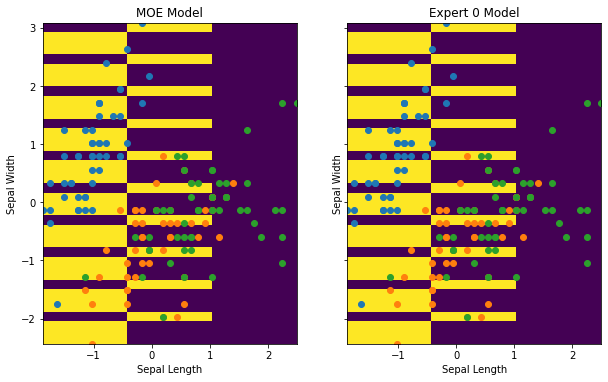

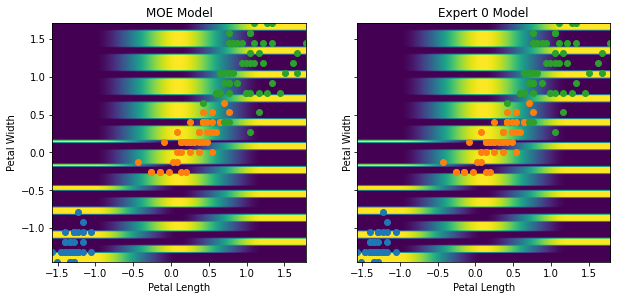

In [92]:
moe_model = models[1]['model']
pred = moe_model.predict(iris_generated_data,batch_size=batch_size)
pred_color,_ = labels(pred)

x = moe_model.get_layer('dense_1')(iris_generated_data.astype('float32'))
pred_exp_0 = moe_model.get_layer('expert_0')(x).numpy()
pred_exp_0_color, _ = labels(pred_exp_0)

nrows = 1
ncols = 2
thefigsize = (10,10)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
ax[0].imshow(pred_color[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[0].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[0].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[0].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[0].set_title('MOE Model')
ax[0].set_ylabel('Sepal Width')
ax[0].set_xlabel('Sepal Length')

ax[1].imshow(pred_exp_0_color[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[1].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[1].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[1].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Sepal Width')
ax[1].set_xlabel('Sepal Length')

plt.savefig('figures/1_expert_sepal.png')

plt.show()

nrows = 1
ncols = 2
thefigsize = (10,10)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
ax[0].imshow(pred_color[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[0].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[0].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[0].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[0].set_title('MOE Model')
ax[0].set_ylabel('Petal Width')
ax[0].set_xlabel('Petal Length')

ax[1].imshow(pred_exp_0_color[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[1].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[1].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[1].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Petal Width')
ax[1].set_xlabel('Petal Length')

plt.savefig('figures/1_expert_petal.png')
plt.show()

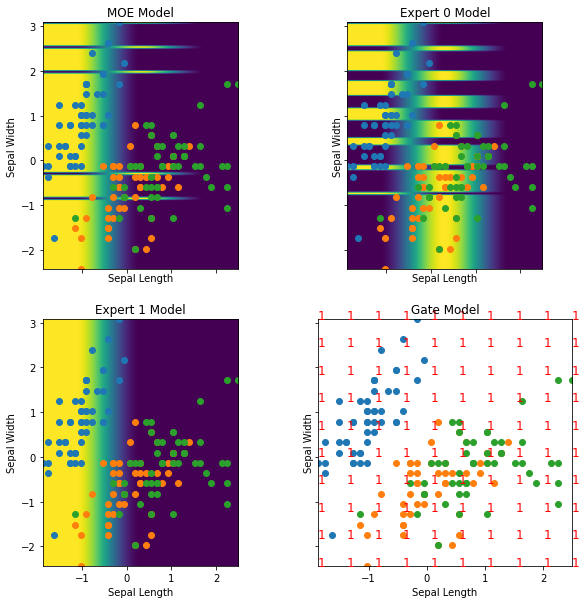

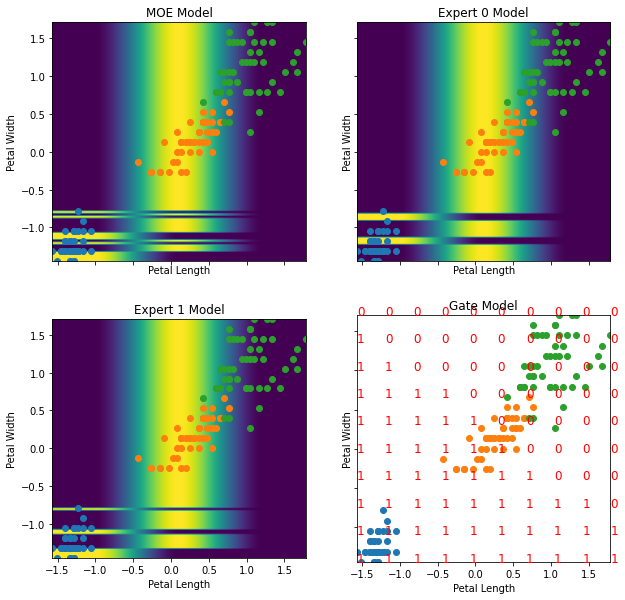

In [93]:
moe_model = models[2]['model']
pred = moe_model.predict(iris_generated_data,batch_size=batch_size)
pred_color, _ = labels(pred)


x = moe_model.get_layer('dense_1')(iris_generated_data.astype('float32'))
pred_exp_0 = moe_model.get_layer('expert_0')(x).numpy()
pred_exp_0_color, _ = labels(pred_exp_0)

x = moe_model.get_layer('dense_2')(iris_generated_data.astype('float32'))
pred_exp_1 = moe_model.get_layer('expert_1')(x).numpy()
pred_exp_1_color, _ = labels(pred_exp_1)

x = moe_model.get_layer('dense')(iris_generated_data.astype('float32'))
pred_gate = moe_model.get_layer('gate_layer')(x).numpy()
pred_gate_labels = np.argmax(pred_gate, axis=1)
pred_exp_0_color, _ = labels(pred_exp_0)

nrows = 2
ncols = 2
thefigsize = (10,10)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
ax[0].imshow(pred_color[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[0].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[0].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[0].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[0].set_title('MOE Model')
ax[0].set_ylabel('Sepal Width')
ax[0].set_xlabel('Sepal Length')

ax[1].imshow(pred_exp_0_color[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[1].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[1].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[1].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Sepal Width')
ax[1].set_xlabel('Sepal Length')

ax[2].imshow(pred_exp_1_color[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[2].scatter(X[y==0, 0], X[y==0,1])
ax[2].scatter(X[y==1, 0], X[y==1,1])
ax[2].scatter(X[y==2, 0], X[y==2,1])
ax[2].set_title('Expert 1 Model')
ax[2].set_ylabel('Sepal Width')
ax[2].set_xlabel('Sepal Length')

xx = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==0, 0]
yy = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==0, 1]
ax[3].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[3].text(xs, ys, str(0), color="red", fontsize=12)
    
xx = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==1, 0]
yy = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==1, 1]
ax[3].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[3].text(xs, ys, str(1), color="red", fontsize=12)
    
ax[3].scatter(X[y==0, 0], X[y==0,1])
ax[3].scatter(X[y==1, 0], X[y==1,1])
ax[3].scatter(X[y==2, 0], X[y==2,1])
ax[3].set_title('Gate Model')
ax[3].set_ylabel('Sepal Width')
ax[3].set_xlabel('Sepal Length')

plt.savefig('figures/2_expert_sepal.png')

plt.show()

nrows = 2
ncols = 2
thefigsize = (10,10)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
ax[0].imshow(pred_color[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[0].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[0].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[0].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[0].set_title('MOE Model')
ax[0].set_ylabel('Petal Width')
ax[0].set_xlabel('Petal Length')


ax[1].imshow(pred_exp_0_color[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[1].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[1].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[1].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Petal Width')
ax[1].set_xlabel('Petal Length')


ax[2].imshow(pred_exp_1_color[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[2].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[2].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[2].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[2].set_title('Expert 1 Model')
ax[2].set_ylabel('Petal Width')
ax[2].set_xlabel('Petal Length')

xx = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==0, 2]
yy = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==0, 3]
ax[3].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[3].text(xs, ys, str(0), color="red", fontsize=12)
    
xx = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==1, 2]
yy = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==1, 3]
ax[3].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[3].text(xs, ys, str(1), color="red", fontsize=12)
    
ax[3].scatter(X[y==0, 2], X[y==0,3])
ax[3].scatter(X[y==1, 2], X[y==1,3])
ax[3].scatter(X[y==2, 2], X[y==2,3])
ax[3].set_title('Gate Model')
ax[3].set_ylabel('Petal Width')
ax[3].set_xlabel('Petal Length')

plt.savefig('figures/2_expert_petal.png')


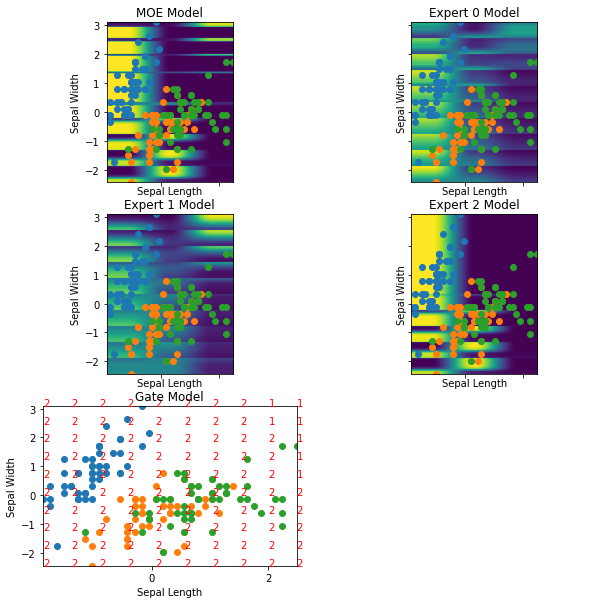

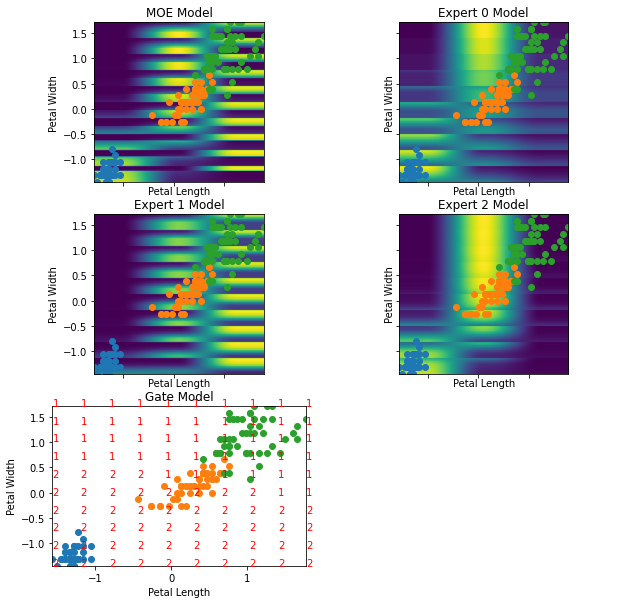

In [96]:
moe_model = models[3]['model']
pred = moe_model.predict(iris_generated_data,batch_size=batch_size)
pred_color, _ = labels(pred)

x = moe_model.get_layer('dense_1')(iris_generated_data.astype('float32'))
pred_exp_0 = moe_model.get_layer('expert_0')(x).numpy()
pred_exp_0_color, _ = labels(pred_exp_0)

x = moe_model.get_layer('dense_2')(iris_generated_data.astype('float32'))
pred_exp_1 = moe_model.get_layer('expert_1')(x).numpy()
pred_exp_1_color, _ = labels(pred_exp_1)

x = moe_model.get_layer('dense_3')(iris_generated_data.astype('float32'))
pred_exp_2 = moe_model.get_layer('expert_2')(x).numpy()
pred_exp_2_color, _ = labels(pred_exp_2)

x = moe_model.get_layer('dense')(iris_generated_data.astype('float32'))
pred_gate = moe_model.get_layer('gate_layer')(x).numpy()
pred_gate_labels = np.argmax(pred_gate, axis=1)

nrows = 3
ncols = 2
thefigsize = (10,10)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
ax[0].imshow(pred[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[0].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[0].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[0].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[0].set_title('MOE Model')
ax[0].set_ylabel('Sepal Width')
ax[0].set_xlabel('Sepal Length')

ax[1].imshow(pred_exp_0[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[1].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[1].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[1].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Sepal Width')
ax[1].set_xlabel('Sepal Length')

ax[2].imshow(pred_exp_1[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[2].scatter(X[y==0, 0], X[y==0,1])
ax[2].scatter(X[y==1, 0], X[y==1,1])
ax[2].scatter(X[y==2, 0], X[y==2,1])
ax[2].set_title('Expert 1 Model')
ax[2].set_ylabel('Sepal Width')
ax[2].set_xlabel('Sepal Length')

ax[3].imshow(pred_exp_2[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[3].scatter(X[y==0, 0], X[y==0,1])
ax[3].scatter(X[y==1, 0], X[y==1,1])
ax[3].scatter(X[y==2, 0], X[y==2,1])
ax[3].set_title('Expert 2 Model')
ax[3].set_ylabel('Sepal Width')
ax[3].set_xlabel('Sepal Length')

xx = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==0, 0]
yy = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==0, 1]
ax[4].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[4].text(xs, ys, str(0), color="red", fontsize=10)
    
xx = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==1, 0]
yy = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==1, 1]
ax[4].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[4].text(xs, ys, str(1), color="red", fontsize=10)
    
xx = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==2, 0]
yy = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==2, 1]
ax[4].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[4].text(xs, ys, str(2), color="red", fontsize=10)
    
ax[4].scatter(X[y==0, 0], X[y==0,1])
ax[4].scatter(X[y==1, 0], X[y==1,1])
ax[4].scatter(X[y==2, 0], X[y==2,1])
ax[4].set_title('Gate Model')
ax[4].set_ylabel('Sepal Width')
ax[4].set_xlabel('Sepal Length')

ax[5].axis('off')
plt.savefig('figures/3_expert_sepal.png')

plt.show()

nrows = 3
ncols = 2
thefigsize = (10,10)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
ax[0].imshow(pred[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[0].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[0].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[0].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[0].set_title('MOE Model')
ax[0].set_ylabel('Petal Width')
ax[0].set_xlabel('Petal Length')


ax[1].imshow(pred_exp_0[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[1].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[1].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[1].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Petal Width')
ax[1].set_xlabel('Petal Length')


ax[2].imshow(pred_exp_1[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[2].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[2].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[2].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[2].set_title('Expert 1 Model')
ax[2].set_ylabel('Petal Width')
ax[2].set_xlabel('Petal Length')

ax[3].imshow(pred_exp_2[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[3].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[3].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[3].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[3].set_title('Expert 2 Model')
ax[3].set_ylabel('Petal Width')
ax[3].set_xlabel('Petal Length')

xx = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==0, 2]
yy = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==0, 3]
ax[4].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[4].text(xs, ys, str(0), color="red", fontsize=10)
    
xx = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==1, 2]
yy = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==1, 3]
ax[4].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[4].text(xs, ys, str(1), color="red", fontsize=10)
    
xx = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==2, 2]
yy = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==2, 3]
ax[4].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[4].text(xs, ys, str(2), color="red", fontsize=10)
    
ax[4].scatter(X[y==0, 2], X[y==0,3])
ax[4].scatter(X[y==1, 2], X[y==1,3])
ax[4].scatter(X[y==2, 2], X[y==2,3])
ax[4].set_title('Gate Model')
ax[4].set_ylabel('Petal Width')
ax[4].set_xlabel('Petal Length')

ax[5].axis('off')

plt.savefig('figures/3_expert_petal.png')



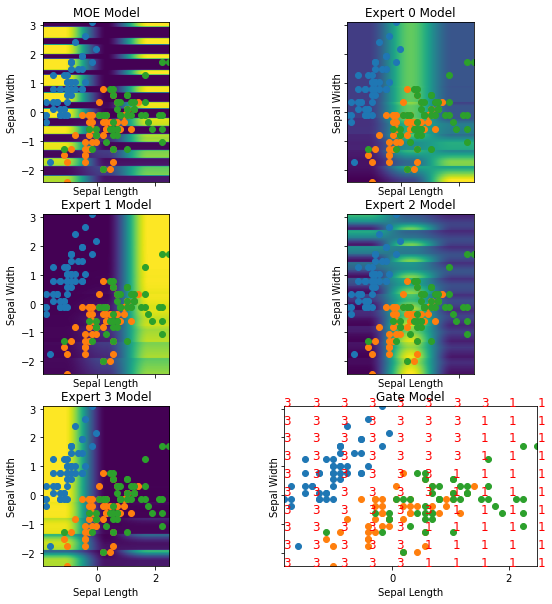

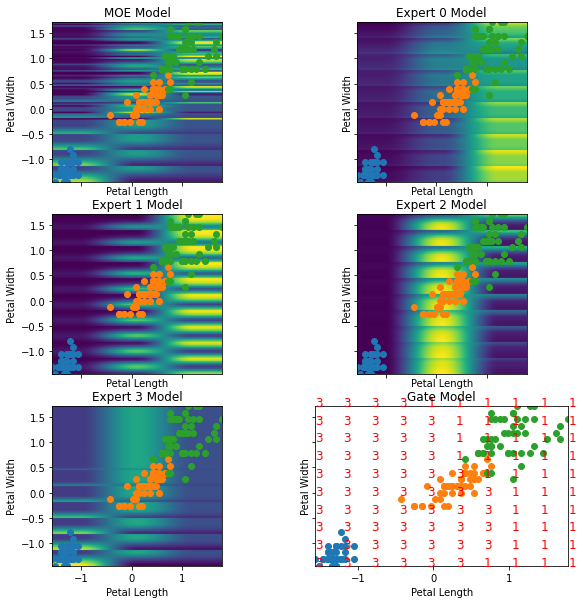

In [97]:
moe_model = models[4]['model']
pred = moe_model.predict(iris_generated_data,batch_size=batch_size)
pred_color, _ = labels(pred)

x = moe_model.get_layer('dense_1')(iris_generated_data.astype('float32'))
pred_exp_0 = moe_model.get_layer('expert_0')(x).numpy()
pred_exp_0_color, _ = labels(pred_exp_0)

x = moe_model.get_layer('dense_2')(iris_generated_data.astype('float32'))
pred_exp_1 = moe_model.get_layer('expert_1')(x).numpy()
pred_exp_1_color, _ = labels(pred_exp_1)

x = moe_model.get_layer('dense_3')(iris_generated_data.astype('float32'))
pred_exp_2 = moe_model.get_layer('expert_2')(x).numpy()
pred_exp_2_color, _ = labels(pred_exp_2)

x = moe_model.get_layer('dense_4')(iris_generated_data.astype('float32'))
pred_exp_3 = moe_model.get_layer('expert_3')(x).numpy()
pred_exp_3_color, _ = labels(pred_exp_3)

x = moe_model.get_layer('dense')(iris_generated_data.astype('float32'))
pred_gate = moe_model.get_layer('gate_layer')(x).numpy()
pred_gate_labels = np.argmax(pred_gate, axis=1)

nrows = 3
ncols = 2
thefigsize = (10,10)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
ax[0].imshow(pred[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[0].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[0].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[0].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[0].set_title('MOE Model')
ax[0].set_ylabel('Sepal Width')
ax[0].set_xlabel('Sepal Length')

ax[1].imshow(pred_exp_0[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[1].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[1].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[1].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Sepal Width')
ax[1].set_xlabel('Sepal Length')

ax[2].imshow(pred_exp_1[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[2].scatter(X[y==0, 0], X[y==0,1])
ax[2].scatter(X[y==1, 0], X[y==1,1])
ax[2].scatter(X[y==2, 0], X[y==2,1])
ax[2].set_title('Expert 1 Model')
ax[2].set_ylabel('Sepal Width')
ax[2].set_xlabel('Sepal Length')

ax[3].imshow(pred_exp_2[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[3].scatter(X[y==0, 0], X[y==0,1])
ax[3].scatter(X[y==1, 0], X[y==1,1])
ax[3].scatter(X[y==2, 0], X[y==2,1])
ax[3].set_title('Expert 2 Model')
ax[3].set_ylabel('Sepal Width')
ax[3].set_xlabel('Sepal Length')

ax[4].imshow(pred_exp_3[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
ax[4].scatter(X[y==0, 0], X[y==0,1])
ax[4].scatter(X[y==1, 0], X[y==1,1])
ax[4].scatter(X[y==2, 0], X[y==2,1])
ax[4].set_title('Expert 3 Model')
ax[4].set_ylabel('Sepal Width')
ax[4].set_xlabel('Sepal Length')

xx = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==0, 0]
yy = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==0, 1]
ax[5].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[5].text(xs, ys, str(0), color="red", fontsize=12)
    
xx = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==1, 0]
yy = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==1, 1]
ax[5].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[5].text(xs, ys, str(1), color="red", fontsize=12)
    
xx = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==2, 0]
yy = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==2, 1]
ax[5].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[5].text(xs, ys, str(2), color="red", fontsize=12)
    
xx = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==3, 0]
yy = iris_generated_data[index_sepals,:][pred_gate_labels[index_sepals]==3, 1]
ax[5].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[5].text(xs, ys, str(3), color="red", fontsize=12)
    
ax[5].scatter(X[y==0, 0], X[y==0,1])
ax[5].scatter(X[y==1, 0], X[y==1,1])
ax[5].scatter(X[y==2, 0], X[y==2,1])
ax[5].set_title('Gate Model')
ax[5].set_ylabel('Sepal Width')
ax[5].set_xlabel('Sepal Length')

plt.savefig('figures/4_expert_sepal.png')

plt.show()

nrows = 3
ncols = 2
thefigsize = (10,10)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
ax[0].imshow(pred[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[0].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[0].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[0].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[0].set_title('MOE Model')
ax[0].set_ylabel('Petal Width')
ax[0].set_xlabel('Petal Length')


ax[1].imshow(pred_exp_0[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[1].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[1].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[1].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Petal Width')
ax[1].set_xlabel('Petal Length')


ax[2].imshow(pred_exp_1[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[2].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[2].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[2].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[2].set_title('Expert 1 Model')
ax[2].set_ylabel('Petal Width')
ax[2].set_xlabel('Petal Length')

ax[3].imshow(pred_exp_2[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[3].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[3].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[3].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[3].set_title('Expert 2 Model')
ax[3].set_ylabel('Petal Width')
ax[3].set_xlabel('Petal Length')

ax[4].imshow(pred_exp_3[index_petals], origin='lower',extent=[pl2d_min,pl2d_max,pw2d_min,pw2d_max])
ax[4].scatter(X[y==0, 2], X[y==0,3], color='tab:blue')
ax[4].scatter(X[y==1, 2], X[y==1,3], color='tab:orange')
ax[4].scatter(X[y==2, 2], X[y==2,3], color='tab:green')
ax[4].set_title('Expert 3 Model')
ax[4].set_ylabel('Petal Width')
ax[4].set_xlabel('Petal Length')


xx = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==0, 2]
yy = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==0, 3]
ax[5].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[5].text(xs, ys, str(0), color="red", fontsize=12)
    
xx = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==1, 2]
yy = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==1, 3]
ax[5].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[5].text(xs, ys, str(1), color="red", fontsize=12)
    
xx = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==2, 2]
yy = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==2, 3]
ax[5].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[5].text(xs, ys, str(2), color="red", fontsize=12)
    
xx = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==3, 2]
yy = iris_generated_data[index_petals,:][pred_gate_labels[index_petals]==3, 3]
ax[5].scatter(xx, yy, color='w')
for xs, ys in zip(xx, yy):
    ax[5].text(xs, ys, str(3), color="red", fontsize=12)
    
ax[5].scatter(X[y==0, 2], X[y==0,3])
ax[5].scatter(X[y==1, 2], X[y==1,3])
ax[5].scatter(X[y==2, 2], X[y==2,3])
ax[5].set_title('Gate Model')
ax[5].set_ylabel('Petal Width')
ax[5].set_xlabel('Petal Length')

plt.savefig('figures/4_expert_petal.png')

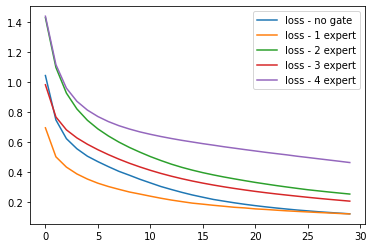

In [49]:
plt.plot(range(len(simple_model_history['loss'])), simple_model_history['loss'])
labels = ['loss - no gate']
for num_experts in range(1, 5):
    plt.plot(range(len(models[num_experts]['history']['loss'])), models[num_experts]['history']['loss'])
    labels.append('loss - ' +str(num_experts)+' expert')
plt.legend(labels)
plt.savefig('figures/loss_moe_exp.png')
plt.show()

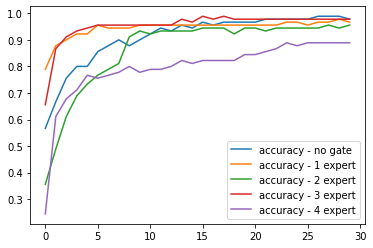

In [50]:
plt.plot(range(len(simple_model_history['accuracy'])), simple_model_history['accuracy'])
labels = ['accuracy - no gate']
for num_experts in range(1, 5):
    plt.plot(range(len(models[num_experts]['history']['accuracy'])), models[num_experts]['history']['accuracy'])
    labels.append('accuracy - ' +str(num_experts)+' expert')
plt.legend(labels)
plt.savefig('figures/loss_moe_stoch.png')
plt.show()

In [ ]:
resolution = 10 # 100x100 background pixels
sl2d_min, sl2d_max = np.min(X[:,0]), np.max(X[:,0])
sw2d_min, sw2d_max = np.min(X[:,1]), np.max(X[:,1])
pl2d_min, pl2d_max = np.min(X[:,2]), np.max(X[:,2])
pw2d_min, pw2d_max = np.min(X[:,3]), np.max(X[:,3])
sl_1, sw_1, pl_1, pw_1 = np.meshgrid(np.linspace(sl2d_min, sl2d_max, resolution), np.linspace(sw2d_min, sw2d_max, resolution), np.linspace(pl2d_min, pl2d_max, resolution),np.linspace(pw2d_min, pw2d_max, resolution))
gen_data = np.c_[sl_1.ravel(), sw_1.ravel(), pl_1.ravel(), pw_1.ravel()]

print(sl_1.shape)
print(sl_1[0])
print(sw_1[0])


In [ ]:
moe_model = models[1]['model']
pred = moe_model.predict(gen_data,batch_size=batch_size)
Z = np.argmax(pred, axis=1)[index_sepals].reshape(10,10)
# plt.imshow(pred[index_sepals], origin='lower',extent=[sl2d_min,sl2d_max,sw2d_min,sw2d_max])
plt.contourf(sl_1[:,0],sw_1[:,1], Z)
plt.xlim(sl2d_min,sl2d_max)
plt.ylim(sw2d_min,sw2d_max)

plt.scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
plt.scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
plt.scatter(X[y==2, 0], X[y==2,1], color='tab:green')
plt.title('MOE Model')
plt.ylabel('Sepal Width')
plt.xlabel('Sepal Length')

In [ ]:
resolution = 0.02
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                       np.arange(x2_min, x2_max, resolution))
xx1.shape
# Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
# Z = Z.reshape(xx1.shape)
# plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
# plt.xlim(xx1.min(), xx1.max())
# plt.ylim(xx2.min(), xx2.max())

In [ ]:
pred = selector_model.predict(x_test, batch_size=batch_size)

In [ ]:
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

In [ ]:
K.mean(categorical_accuracy(y_test, pred))

In [ ]:
x = selector_model.get_layer('dense_1')(x_test)
pred = selector_model.get_layer('expert_0')(x)
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

In [ ]:
x = selector_model.get_layer('dense_2')(x_test)
pred = selector_model.get_layer('expert_1')(x)
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

In [ ]:
x = selector_model.get_layer('dense_3')(x_test)
pred = selector_model.get_layer('expert_2')(x)
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

### Comparing activations of standalone expert network to an expert of MOE

In [ ]:
plt.plot(range(len( simple_model_cb.simple_model_mean_abs_act)), simple_model_cb.simple_model_mean_abs_act,color='tab:cyan')
labels = ['standalone']
for key, expert in analysis_cb.expert_mean_abs_act.items():
    plt.plot(range(len( analysis_cb.expert_mean_abs_act[key])), analysis_cb.expert_mean_abs_act[key])
    labels.append('expert '+ str(key-1))
plt.legend(labels)
plt.show()

### Comparing predictions of standalone expert network with the predictions of the MOE network

In [ ]:
pred = simple_model.predict(x_test, batch_size=batch_size)
pred

In [ ]:
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

In [ ]:
y_test

In [ ]:
# PCA projection of actual and predicted targets with standalone expert
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(x_test)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y_test == i,0], coord[y_test == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()
for i in range(3):
    plt.scatter(coord[pred == i,0], coord[pred == i, 1],color=colors1[i], marker=markers[i])
plt.title('Predicted Output')
plt.show()

In [ ]:
pred = selector_model.predict(x_test, batch_size=batch_size)
pred

In [ ]:
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

In [ ]:
# PCA projection of actual and predicted targets with MOE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(x_test)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y_test == i,0], coord[y_test == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()
for i in range(3):
    plt.scatter(coord[pred == i,0], coord[pred == i, 1],color=colors1[i], marker=markers[i])
plt.title('Predicted Output')
plt.show()

### Mixture of Experts model with the gate output fixed at [1,0,0]

In [ ]:
K.clear_session()

In [ ]:
#Gate network (Similar to the expert layer) with a fixed output of [1, 0, 0]
def gate_layers_fixed(input, output, name):
#     x = layers.Dense(1000, activation='relu', kernel_initializer=initializers.Zeros(), 
#                      bias_initializer=initializers.Zeros())(input)
#     x = layers.Dense(500, activation='relu', kernel_initializer=initializers.Zeros(), 
#                      bias_initializer=initializers.Zeros())(x)
    x = layers.Dense(10,activation='sigmoid', kernel_initializer=initializers.Zeros(), 
                     bias_initializer=initializers.Zeros())(input)
    x = layers.Dense(output, activation='softmax',name=name, kernel_initializer=initializers.Zeros(), 
                     bias_initializer=tf.constant_initializer([3.]+[0.]*(output-1)))(x)
    return x

In [ ]:
num_experts = 3

In [ ]:
#Initialize gate network
gate = gate_layers_fixed(input, num_experts, 'gate_layer')

In [ ]:
#Initialize expert networks
experts = []
for i in range(num_experts):
    experts.append(expert_layers(input, 3, 'expert_'+str(i)))

In [ ]:
# Initialize the selector network
expert_output = experts[0]
if num_experts > 1:
    expert_output = tf.keras.layers.Concatenate(axis=0)(experts)
selector_output = selector_expectation(num_experts=num_experts, trainable=False)([expert_output, gate])

In [ ]:
selector_model = CustomModel(input, selector_output,name='selector')

In [ ]:
selector_model.summary()

In [ ]:
selector_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics="accuracy")

In [ ]:
analysis_cb = AnalysisCallback(num_experts)

In [ ]:
selector_model.fit(x_train, y_train_onehot, epochs=10, batch_size=batch_size)
#                    , shuffle=True, callbacks=[analysis_cb])

In [ ]:
pred = selector_model.predict(x_test, batch_size=batch_size)
pred

In [ ]:
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

In [ ]:
# PCA projection of actual and predicted targets with MOE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(x_test)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y_test == i,0], coord[y_test == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()
for i in range(3):
    plt.scatter(coord[pred == i,0], coord[pred == i, 1],color=colors1[i], marker=markers[i])
plt.title('Predicted Output')
plt.show()

In [ ]:
# PCA projection of actual and predicted targets with MOE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(X)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y == i,0], coord[y == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()

In [ ]:
# PCA projection of actual and predicted targets with MOE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(x_test)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y_test == i,0], coord[y_test == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()
for i in range(3):
    plt.scatter(coord[pred == i,0], coord[pred == i, 1],color=colors1[i], marker=markers[i])
plt.title('Predicted Output')
plt.show()